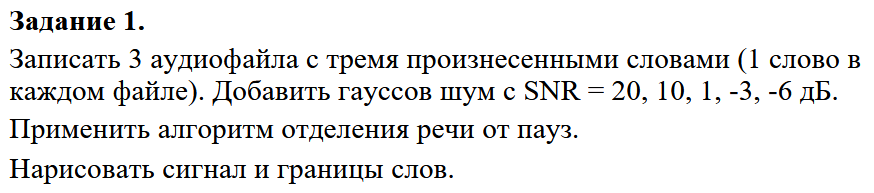

In [6]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

In [7]:
def noise(signal, SNR, silence_duration_ms=100):
    noise = np.sqrt(np.var(signal) / (10.0 ** (SNR / 10.0))) * np.random.randn(len(signal))
    return signal + noise

def energy(signal, window_length_ms, sample_rate):
    window_length = int(sample_rate * window_length_ms / 1000)
    energy_values = []
    for i in range(0, len(signal), window_length):
        window = signal[i:i + window_length]
        energy_values.append(np.mean(window**2))
    return np.array(energy_values)

def separation(signal, energy_values, ITU, ITL, IZCT, window_length_ms, sample_rate):
    speech = np.where(energy_values > ITU)[0]

    # Начало речи
    for i in range(speech[0] - 1, -1, -1):
        if energy_values[i] < ITL:
            start = i + 1
            break

    zcr_cnt = 0
    backtrack_range = min(25, start)

    window_length = int(sample_rate * window_length_ms / 1000)
    for i in range(start, max(start - backtrack_range - 1, -1), -1):
        window = signal[i * window_length:(i + 1) * window_length]
        crossings = len(np.where(np.diff(np.signbit(window)))[0])
        if crossings > IZCT:
            zcr_cnt += 1

    if zcr_cnt >= 3:
        for i in range(start, max(start - backtrack_range - 1, -1), -1):
            window = signal[i * window_length:(i + 1) * window_length]
            crossings = len(np.where(np.diff(np.signbit(window)))[0])
            if crossings > IZCT:
                start = i
                break

    # Конец речи
    end = speech[-1]
    for i in range(speech[-1] + 1, len(energy_values)):
        if energy_values[i] < ITL:
            end = i - 1
            break

    zcr_cnt = 0
    forwardtrack_range = min(25, len(energy_values) - 1 - end)

    for i in range(end, min(end + forwardtrack_range + 1, len(energy_values))):
        window = signal[i * window_length:(i + 1) * window_length]
        crossings = len(np.where(np.diff(np.signbit(window)))[0])
        if crossings > IZCT:
            zcr_cnt += 1

    if zcr_cnt >= 3:
        for i in range(end, min(end + forwardtrack_range + 1, len(energy_values))):
            window = signal[i * window_length:(i + 1) * window_length]
            crossings = len(np.where(np.diff(np.signbit(window)))[0])
            if crossings > IZCT:
                end = i
                break

    return start * window_length, end * window_length

def analyze_audio(audio_path, SNR, silence_duration_ms=100, window_length_ms=10):
    sample_rate, signal = wav.read(audio_path)
    signal = signal / np.max(np.abs(signal))
    noisy_signal = noise(signal, SNR, silence_duration_ms)

    energy_values = energy(noisy_signal, window_length_ms, sample_rate)

    silence_samples = int(sample_rate * silence_duration_ms / 1000)
    silence_segment = signal[:silence_samples]
    mean_silence = np.mean(silence_segment)
    std_silence = np.std(silence_segment)
    IZCT = min(0.25, mean_silence + 2 * std_silence)

    IMX = np.max(energy_values)
    IMN = np.min(energy_values)
    I1 = 0.03 * (IMX - IMN) + IMN
    I2 = 4 * IMN
    ITL = min(I1, I2)
    ITU = 5 * ITL

    start, end = separation(noisy_signal, energy_values, ITU, ITL, IZCT, window_length_ms, sample_rate)

    plt.figure(figsize=(10, 12))

    plt.subplot(4, 1, 1)
    plt.plot(signal)
    plt.title('Signal')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.grid()

    plt.subplot(4, 1, 2)
    plt.plot(noisy_signal)
    plt.title(f'Noisy Signal')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.grid()

    plt.subplot(4, 1, 3)
    plt.plot(np.arange(0, len(noisy_signal), int(sample_rate * window_length_ms / 1000)), energy_values)
    plt.axhline(ITU, color='r', linestyle='--', label='ITU')
    plt.axhline(ITL, color='g', linestyle='--', label='ITL')
    plt.title('Energy')
    plt.xlabel('Samples')
    plt.ylabel('Energy')
    plt.legend()
    plt.grid()

    plt.subplot(4, 1, 4)
    plt.plot(noisy_signal)
    plt.axvline(x=start, color='r', linestyle='--', label='Word start')
    plt.axvline(x=end, color='g', linestyle='--', label='Word end')
    plt.title('Word')
    plt.xlabel('Signal')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

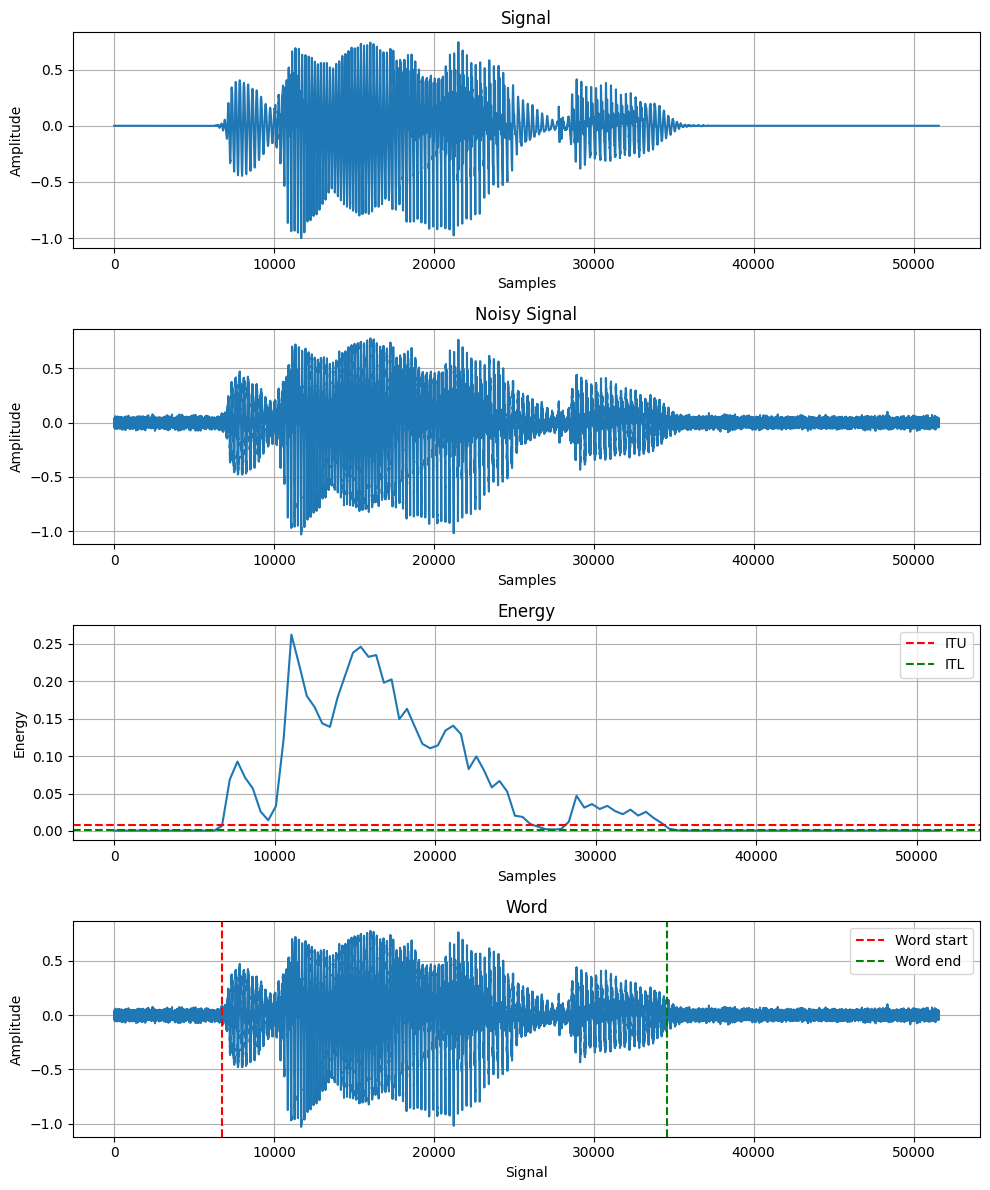

In [8]:
analyze_audio('word_3.wav', SNR=20)

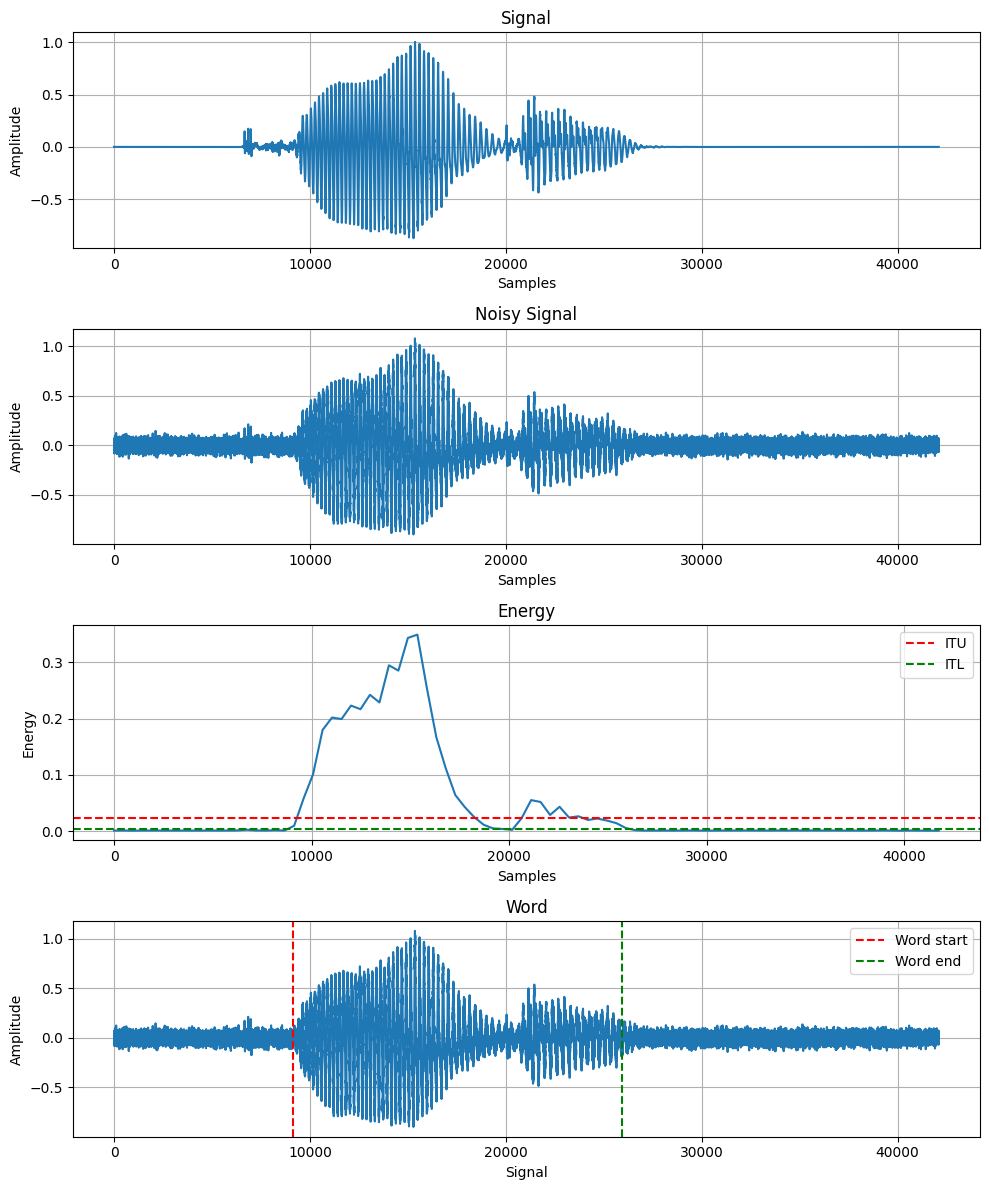

In [9]:
analyze_audio('word_2.wav', SNR=15)

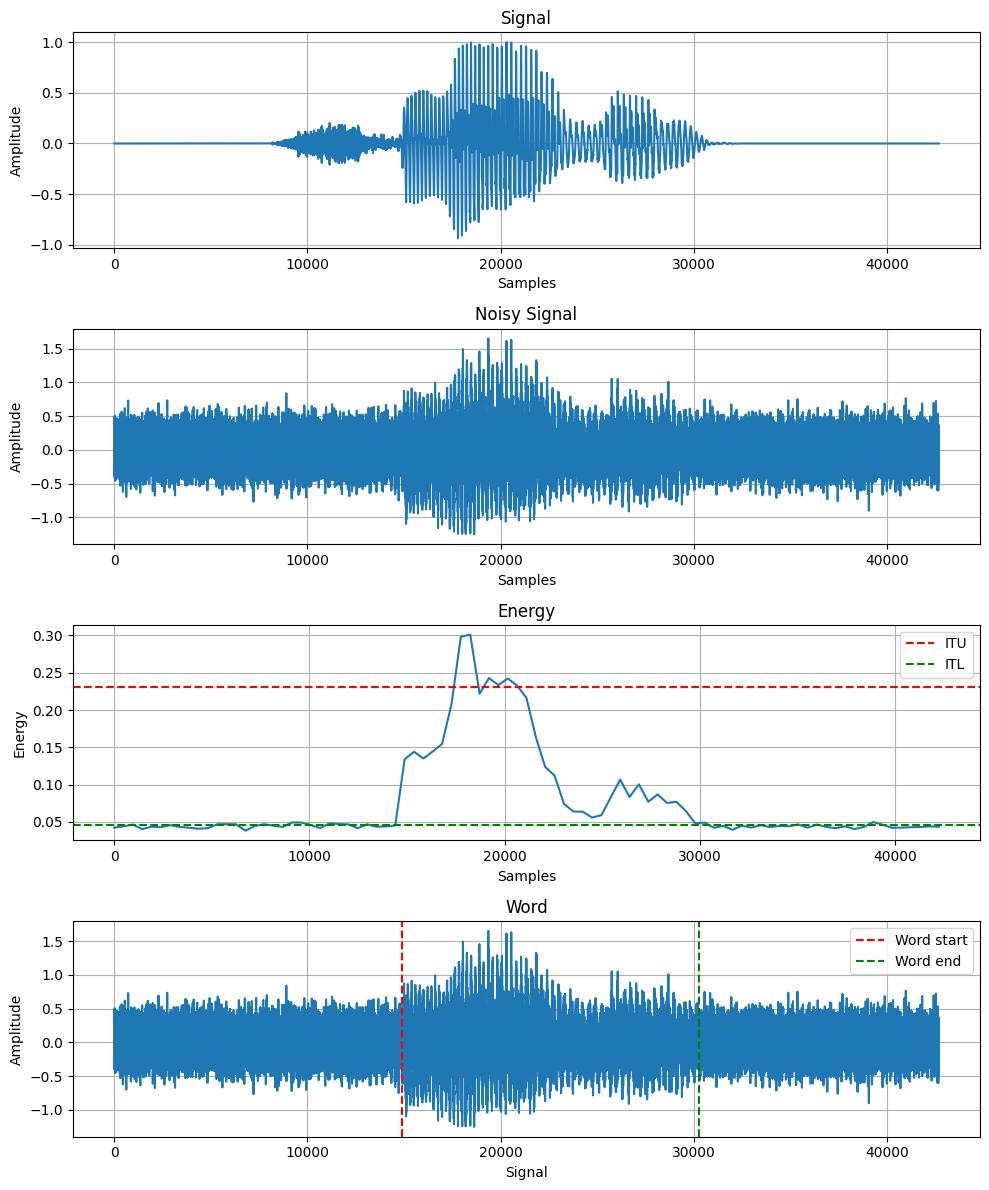

In [10]:
analyze_audio('word_1.wav', SNR=-1)